# Auto Encoders and Variational Auto Encoders on MNIST

In this notebook we are going to demonstrate Auto Encoder and Variational Auto Encoder models on MNIST data.  

We will go through many visualizations to develop good intuition on how these models work.

### Set GPU for Runtime

<p id="7ecb" class="gy gz ef at ha b hb ja hd jb hf jc hh jd hj je hl" data-selectable-paragraph="">It is so simple to alter default hardware <strong class="ha hm">(CPU to GPU or vice versa)</strong>; just follow <strong class="ha hm">Edit &gt; Notebook settings</strong> or <strong class="ha hm">Runtime&gt;Change runtime type </strong>and <strong class="ha hm">select GPU </strong>as <strong class="ha hm">Hardware accelerator</strong>.</p>

![tittle](https://miro.medium.com/max/740/1*WNovJnpGMOys8Rv7YIsZzA.png)

### Imports

In [1]:
# Python lib
import os
from typing import List, Tuple

# Scientific utilities
import numpy as np
import pandas as pd
from scipy.stats import norm as ndist

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# Vizualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Globals

In [2]:
DATA_DIR = 'data'

BATCH_SIZE = 128

### Preparing Data

Conveniently, PyTorch comes with pre-defined MNIST dataset so we are going to use it directly.

In [3]:
def get_mnist_ds(train: bool):

    return torchvision.datasets.MNIST(DATA_DIR, 
                                      train=train, 
                                      transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                                ]), 
                                      target_transform=None, 
                                      download=True)

def get_mnist_dls():
    
    train_ds = get_mnist_ds(train=True)
    valid_ds = get_mnist_ds(train=False)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=False))

In [4]:
train_dl, valid_dl = get_mnist_dls()

In [5]:
len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

### Displaying first images from batch and some stats of batch. 

torch.Size([128, 1, 28, 28]) tensor(0.1333) tensor(0.3109) tensor(0.) tensor(1.)


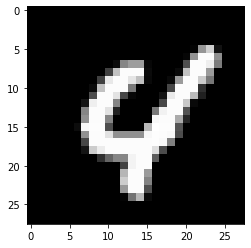

torch.Size([128, 1, 28, 28]) tensor(0.1297) tensor(0.3070) tensor(0.) tensor(1.)


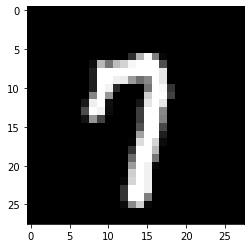

torch.Size([128, 1, 28, 28]) tensor(0.1303) tensor(0.3082) tensor(0.) tensor(1.)


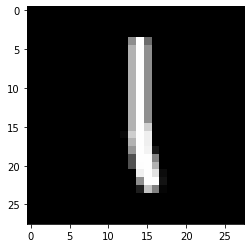

torch.Size([128, 1, 28, 28]) tensor(0.1261) tensor(0.3027) tensor(0.) tensor(1.)


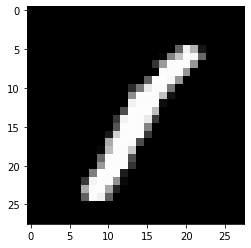

In [6]:
for i, (x, y) in enumerate(train_dl):
    print(x.shape, x.mean(), x.std(), x.min(), x.max())
    plt.imshow(x[0][0], cmap='gray')
    plt.show()
    if i > 2: break

## Vanilla Auto Encoder

Here we define simplest Auto Encoder with simple linear layers and ReLU activations in Encoder and Decoder parts. The architecture is somewhat similar to one showed bellow.`

![title](https://miro.medium.com/max/2496/1*PVm-Y50e3HPOsD9my2sv4A.png)

### Weights initialization

This is helper function for initializing weights of the model. Read more about kaiming initialization [here](https://arxiv.org/abs/1502.01852) 

In [7]:
def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            nn.init.constant_(m.bias, 0)

### Encoder Module

We fill be using simple encoder with one hidden layer and Relu activation.

Steps: 
- 28*28 -> 784 (Flatten)
- 784 -> 512 (Linear)
- 512 -> 512 (ReLU)
- 512 -> 256 (Linear)

In [8]:
class Encoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_shape), hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, out_dim))
        
        init_weights(self)
        
    def forward(self, x): 
        return self.enc(x)

In [9]:
Encoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)

Encoder(
  (enc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
  )
)

### Decoder Module

We fill be using simple encoder with one hidden layer and Relu activation.

Steps: 
- 256 -> 512 (Linear)
- 512 -> 512 (ReLU)
- 512 -> 784 (Linear)
- 784 -> 28*28 (Reshape into original form in `forward`)

In [10]:
class Decoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.inp_shape = inp_shape
        
        self.dec = nn.Sequential(nn.Linear(out_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, np.prod(inp_shape)))
        
        init_weights(self)
        
    def forward(self, x): 
        return torch.sigmoid(self.dec(x)).view(x.shape[0], *self.inp_shape)

In [11]:
Decoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)

Decoder(
  (dec): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
  )
)

### Auto Encoder Module

We just combine encoder and decoder modules from above to get full `Auto Encoder` network

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.ae = nn.Sequential(Encoder(inp_shape, hidden_dim, out_dim),
                                Decoder(inp_shape, hidden_dim, out_dim))
        
    def forward(self, x): 
        return self.ae(x)

In [13]:
ae = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256)
ae

AutoEncoder(
  (ae): Sequential(
    (0): Encoder(
      (enc): Sequential(
        (0): Flatten()
        (1): Linear(in_features=784, out_features=512, bias=True)
        (2): ReLU()
        (3): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (1): Decoder(
      (dec): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
  )
)

### Check Input/output shapes

We make sure that auto encoder output has same shape as the input

In [14]:
sample_input = torch.randn(BATCH_SIZE, 1, 28, 28)

assert ae(sample_input).shape == sample_input.shape

### Helper function

In [15]:
def show_summary(valid_dl: DataLoader, model: nn.Module):
    """This is a helper function for visualizing model output quality during the training process."""
    
    N_SAMPLES = 15
    
    model.eval()
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            
            actuals.append(x)
            
            recon_x = model(x.unsqueeze(0).cuda()).cpu()
            
            preds.append(recon_x.squeeze(0))
            
            if i + 1 == N_SAMPLES:
                break
                
    model.train()
            
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()  

### Training loop

In [16]:
 def train_ae(train_dl: DataLoader, 
             valid_dl: DataLoader,
             model: nn.Module,
             n_epochs: int,
             max_iters: int = -1):
    
    LOG_INTERVAL = 5
    SUMMARY_INTERVAL = 10
    
    model = model.cuda() # moving our model on GPU.
    
    # defining loss function and optimizer (we will use Adam here)
    crit = nn.MSELoss(reduction='mean')
    optim = torch.optim.Adam(model.parameters())
    
    acc_loss = 0
    
    i = 1
    for epoch in range(n_epochs):
        for x, _ in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()
            
            x_recon = model(x)
            
            loss = crit(x, x_recon)
            
            acc_loss += loss.item()
            
            loss.backward() # computing the gradients
            
            optim.step() # updating model weights
            
            if (i + 1) % LOG_INTERVAL == 0:
                print('epoch %d | iter %d | loss %.5f' % (epoch + 1, i + 1, acc_loss / LOG_INTERVAL))
                acc_loss = 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return

### Train Auto Encoder

Now we will train the mode. You can play with out_dim parameter (latent vector size) and see how it affects training speed and image reconstruction quality.

Let's train on 500 iterations.

In [17]:
ae = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=20)

In [18]:
ae

AutoEncoder(
  (ae): Sequential(
    (0): Encoder(
      (enc): Sequential(
        (0): Flatten()
        (1): Linear(in_features=784, out_features=512, bias=True)
        (2): ReLU()
        (3): Linear(in_features=512, out_features=20, bias=True)
      )
    )
    (1): Decoder(
      (dec): Sequential(
        (0): Linear(in_features=20, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
  )
)

epoch 1 | iter 5 | loss 0.17245
epoch 1 | iter 10 | loss 0.12736


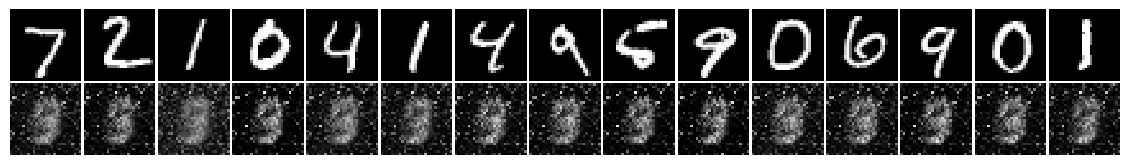

epoch 1 | iter 15 | loss 0.07767
epoch 1 | iter 20 | loss 0.06834


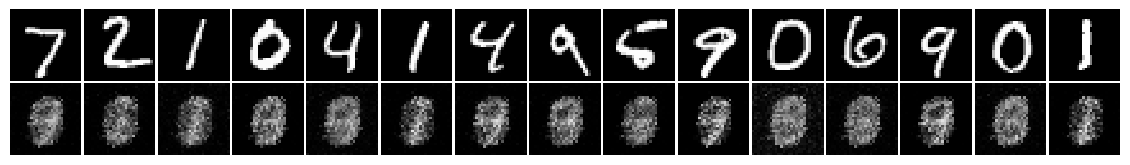

epoch 1 | iter 25 | loss 0.06448
epoch 1 | iter 30 | loss 0.05927


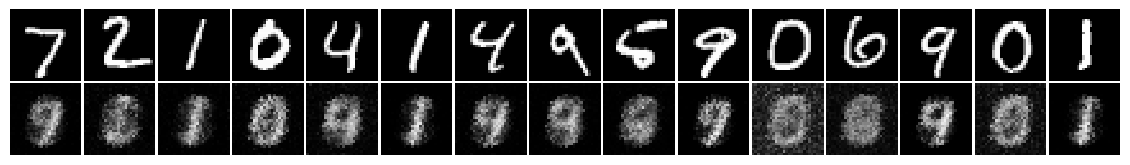

epoch 1 | iter 35 | loss 0.05595
epoch 1 | iter 40 | loss 0.05212


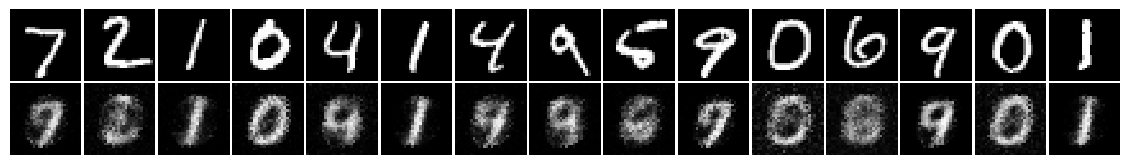

epoch 1 | iter 45 | loss 0.04722
epoch 1 | iter 50 | loss 0.04508


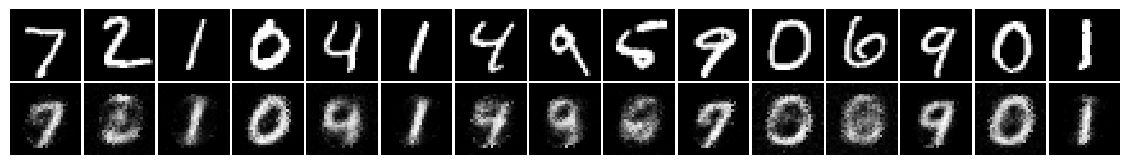

epoch 1 | iter 55 | loss 0.04109
epoch 1 | iter 60 | loss 0.04035


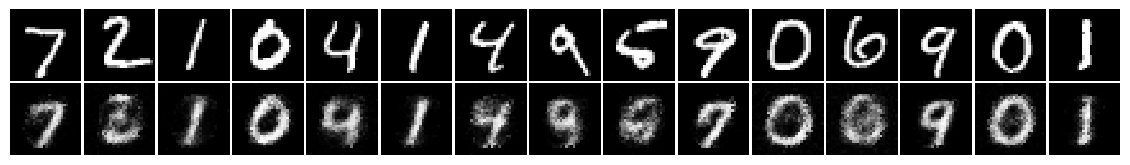

epoch 1 | iter 65 | loss 0.03770
epoch 1 | iter 70 | loss 0.03608


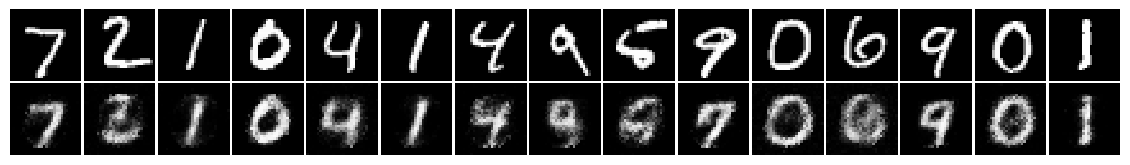

epoch 1 | iter 75 | loss 0.03360
epoch 1 | iter 80 | loss 0.03152


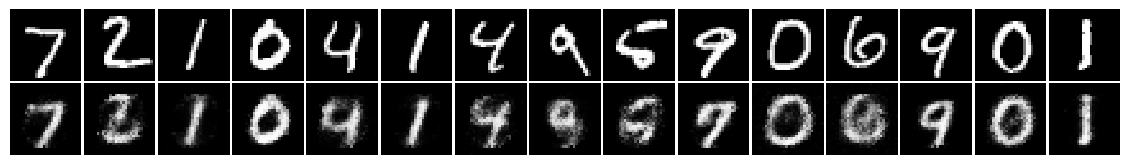

epoch 1 | iter 85 | loss 0.03166
epoch 1 | iter 90 | loss 0.03039


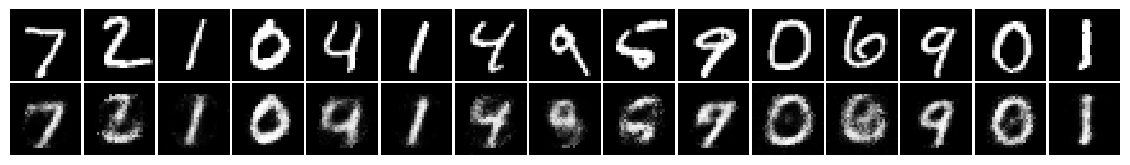

epoch 1 | iter 95 | loss 0.02984
epoch 1 | iter 100 | loss 0.02877


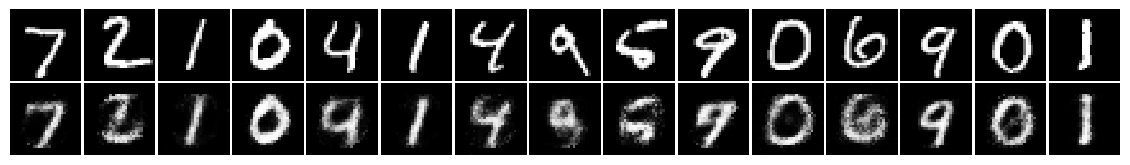

epoch 1 | iter 105 | loss 0.02762
epoch 1 | iter 110 | loss 0.02697


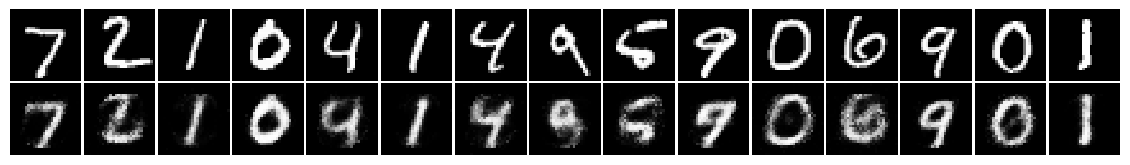

epoch 1 | iter 115 | loss 0.02609
epoch 1 | iter 120 | loss 0.02530


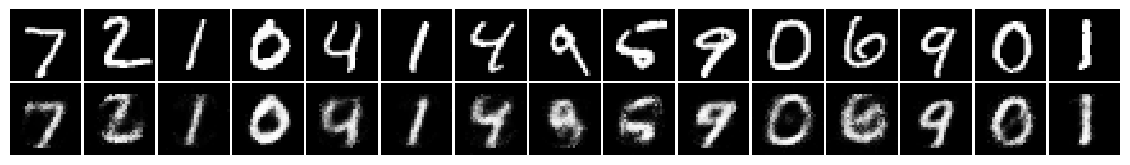

epoch 1 | iter 125 | loss 0.02483
epoch 1 | iter 130 | loss 0.02402


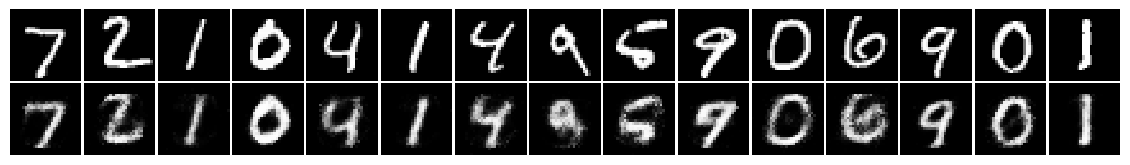

epoch 1 | iter 135 | loss 0.02396
epoch 1 | iter 140 | loss 0.02330


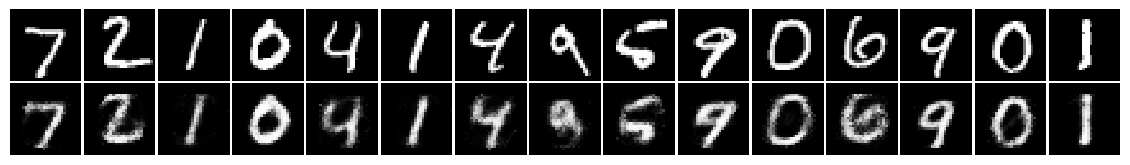

epoch 1 | iter 145 | loss 0.02282
epoch 1 | iter 150 | loss 0.02280


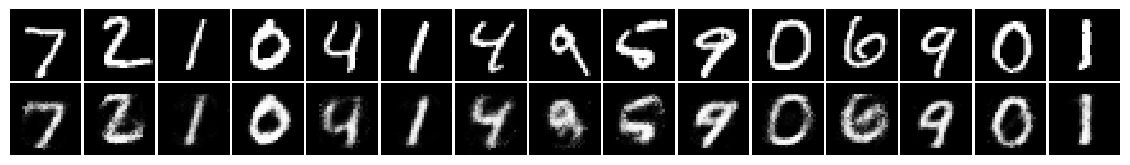

epoch 1 | iter 155 | loss 0.02241
epoch 1 | iter 160 | loss 0.02168


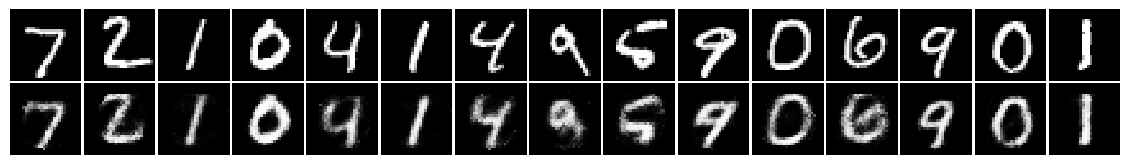

epoch 1 | iter 165 | loss 0.02136
epoch 1 | iter 170 | loss 0.02073


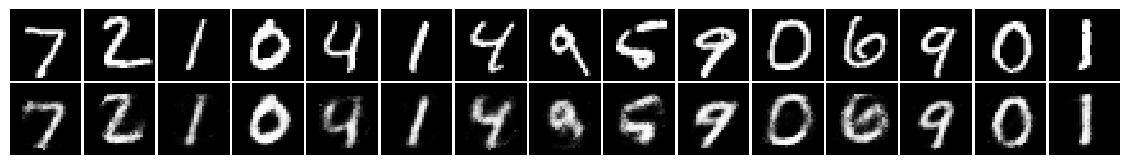

epoch 1 | iter 175 | loss 0.02088
epoch 1 | iter 180 | loss 0.02055


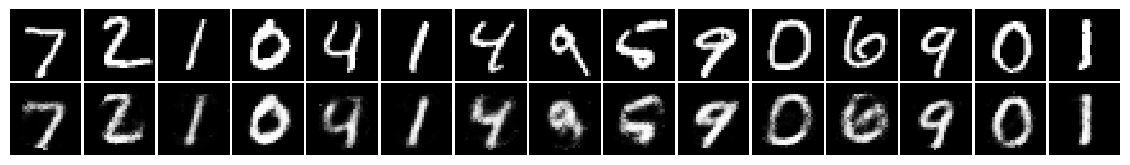

epoch 1 | iter 185 | loss 0.02093
epoch 1 | iter 190 | loss 0.02013


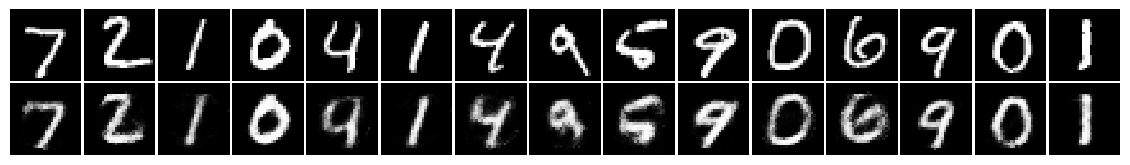

epoch 1 | iter 195 | loss 0.01952
epoch 1 | iter 200 | loss 0.01945


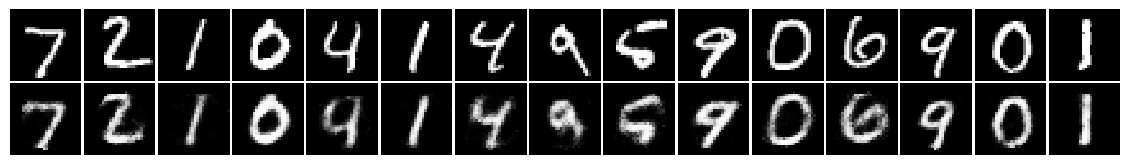

epoch 1 | iter 205 | loss 0.01940
epoch 1 | iter 210 | loss 0.01974


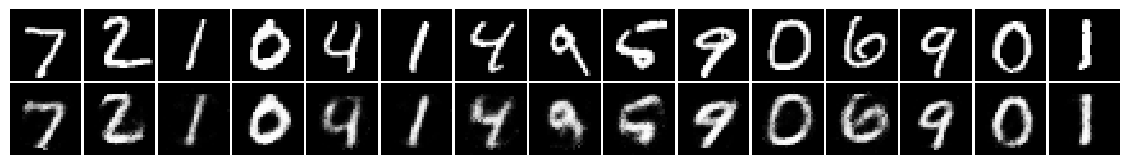

epoch 1 | iter 215 | loss 0.01852
epoch 1 | iter 220 | loss 0.01856


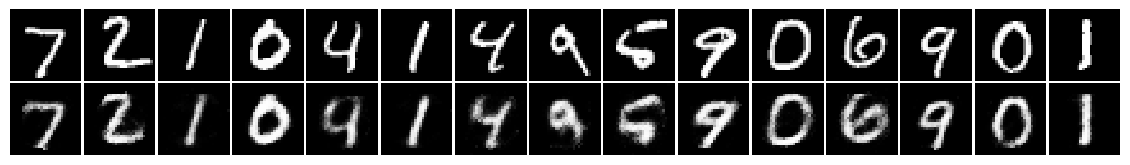

epoch 1 | iter 225 | loss 0.01870
epoch 1 | iter 230 | loss 0.01888


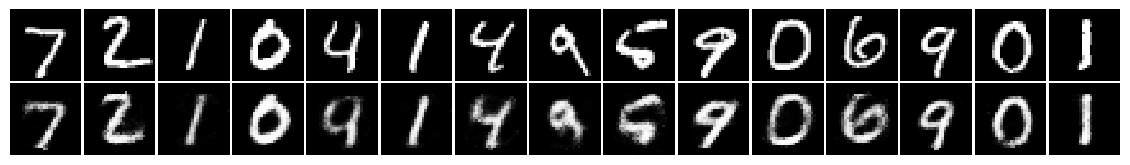

epoch 1 | iter 235 | loss 0.01832
epoch 1 | iter 240 | loss 0.01863


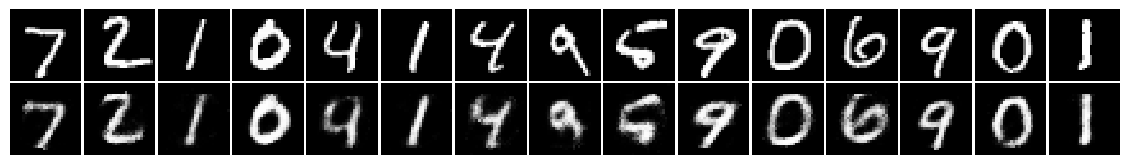

epoch 1 | iter 245 | loss 0.01872
epoch 1 | iter 250 | loss 0.01792


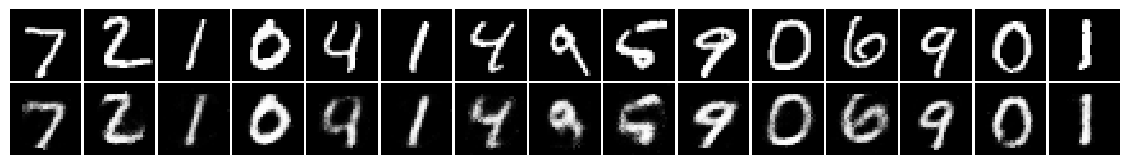

epoch 1 | iter 255 | loss 0.01753
epoch 1 | iter 260 | loss 0.01761


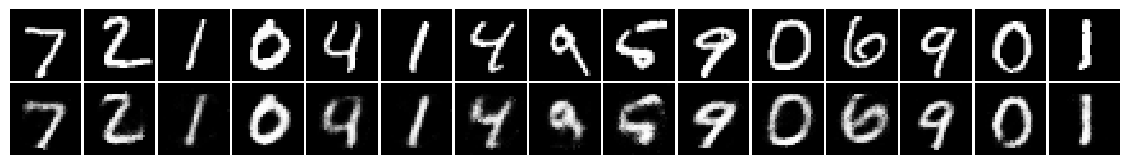

epoch 1 | iter 265 | loss 0.01759
epoch 1 | iter 270 | loss 0.01856


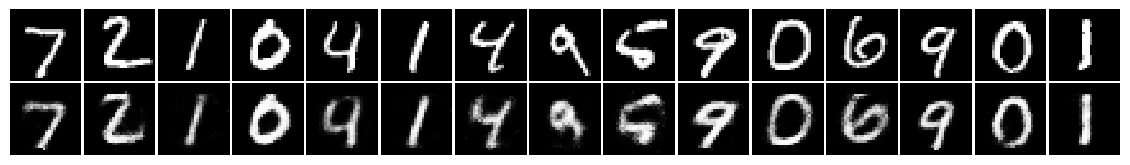

epoch 1 | iter 275 | loss 0.01713
epoch 1 | iter 280 | loss 0.01739


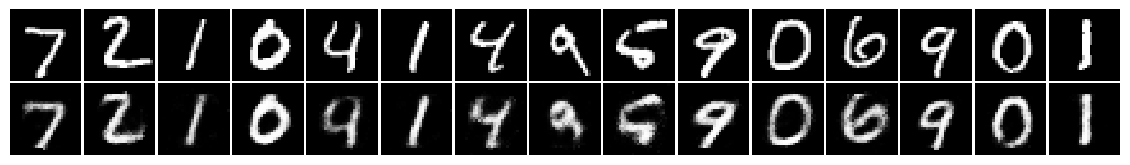

epoch 1 | iter 285 | loss 0.01710
epoch 1 | iter 290 | loss 0.01697


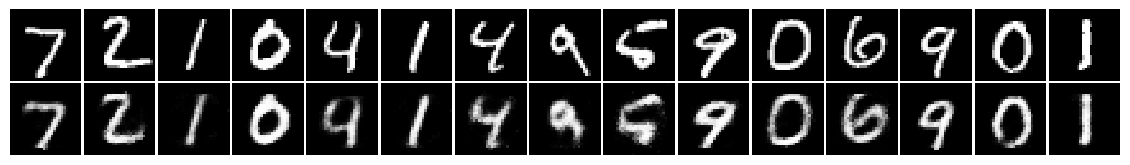

epoch 1 | iter 295 | loss 0.01717
epoch 1 | iter 300 | loss 0.01723


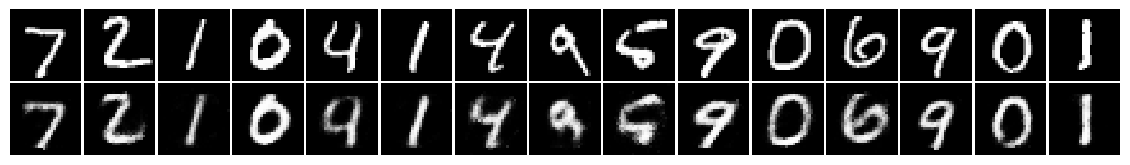

epoch 1 | iter 305 | loss 0.01653
epoch 1 | iter 310 | loss 0.01716


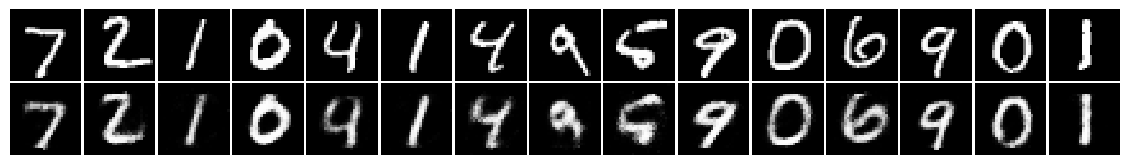

epoch 1 | iter 315 | loss 0.01722
epoch 1 | iter 320 | loss 0.01706


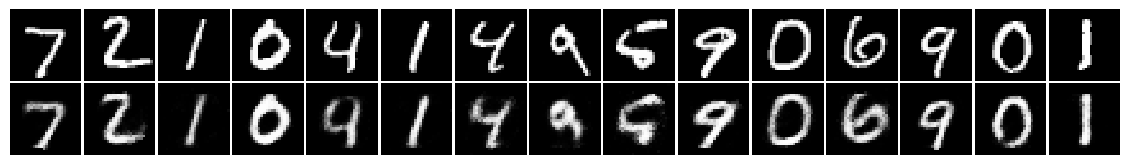

epoch 1 | iter 325 | loss 0.01627
epoch 1 | iter 330 | loss 0.01721


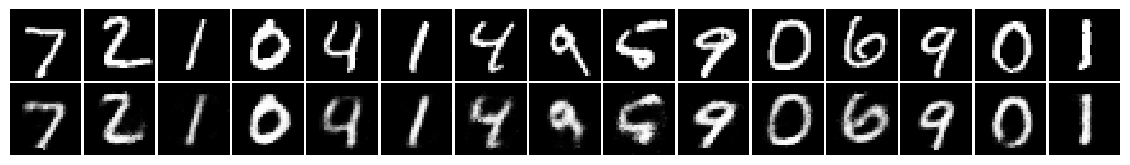

epoch 1 | iter 335 | loss 0.01697
epoch 1 | iter 340 | loss 0.01647


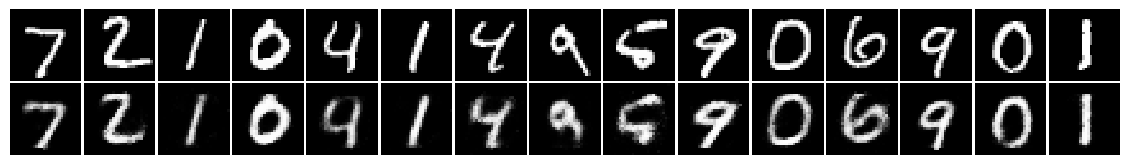

epoch 1 | iter 345 | loss 0.01664
epoch 1 | iter 350 | loss 0.01612


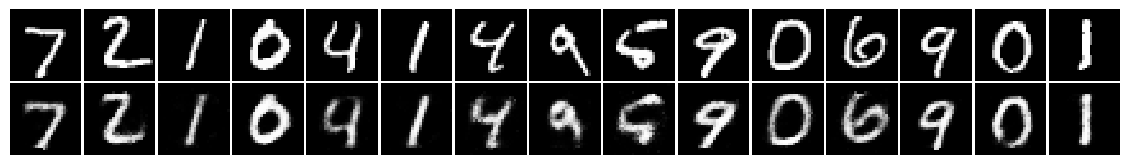

epoch 1 | iter 355 | loss 0.01694
epoch 1 | iter 360 | loss 0.01630


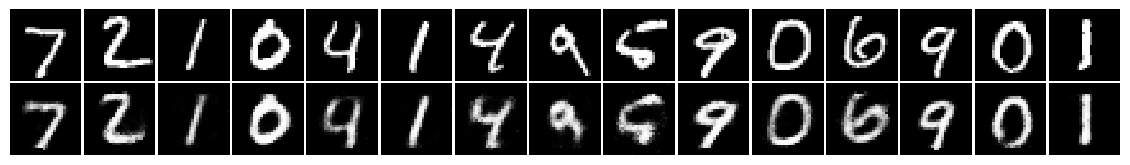

epoch 1 | iter 365 | loss 0.01608
epoch 1 | iter 370 | loss 0.01619


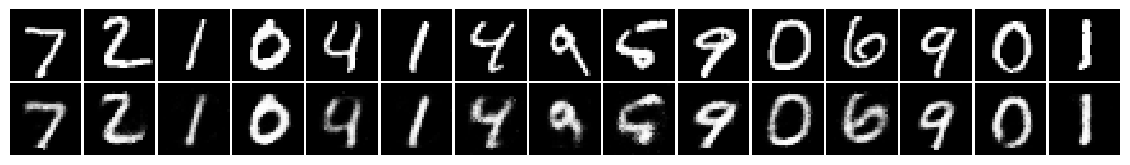

epoch 1 | iter 375 | loss 0.01597
epoch 1 | iter 380 | loss 0.01572


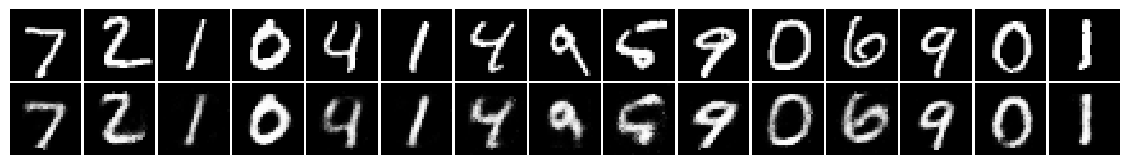

epoch 1 | iter 385 | loss 0.01569
epoch 1 | iter 390 | loss 0.01584


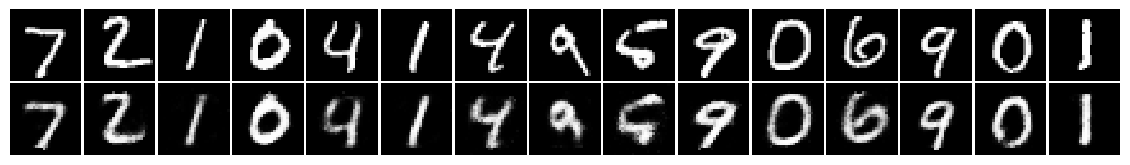

epoch 1 | iter 395 | loss 0.01546
epoch 1 | iter 400 | loss 0.01588


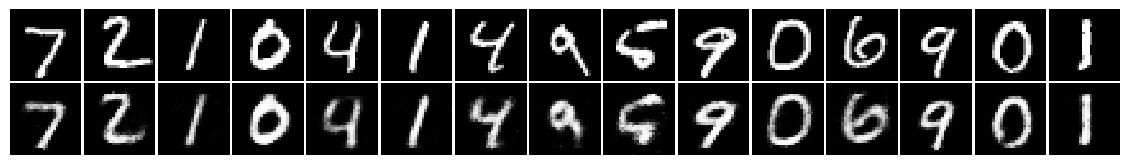

epoch 1 | iter 405 | loss 0.01600
epoch 1 | iter 410 | loss 0.01613


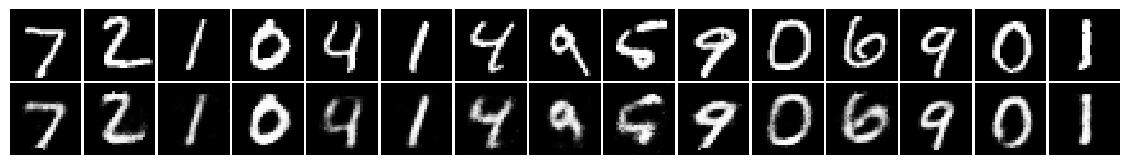

epoch 1 | iter 415 | loss 0.01544
epoch 1 | iter 420 | loss 0.01581


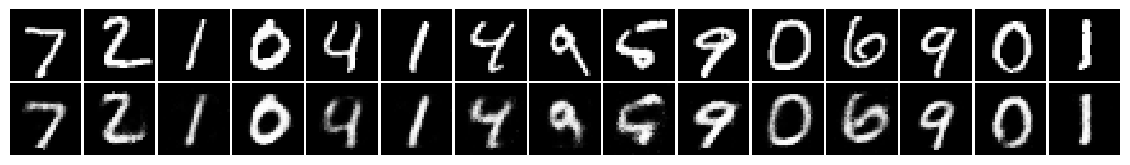

epoch 1 | iter 425 | loss 0.01500
epoch 1 | iter 430 | loss 0.01463


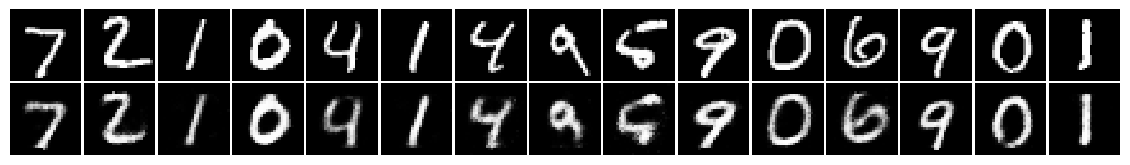

epoch 1 | iter 435 | loss 0.01481
epoch 1 | iter 440 | loss 0.01528


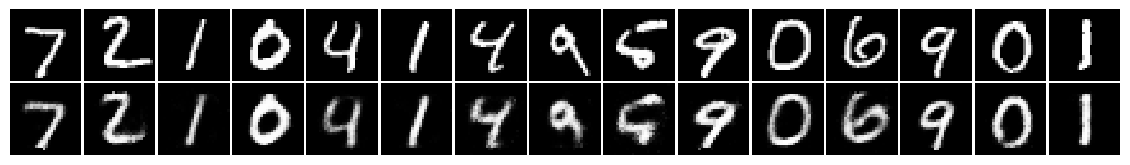

epoch 1 | iter 445 | loss 0.01515
epoch 1 | iter 450 | loss 0.01496


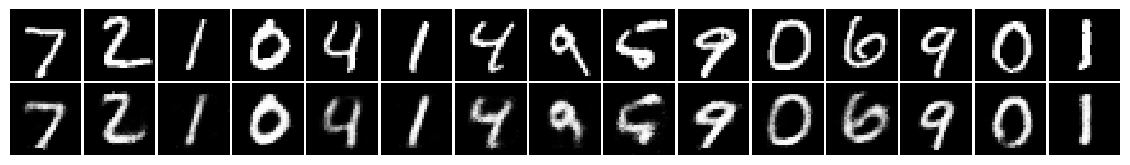

epoch 1 | iter 455 | loss 0.01503
epoch 1 | iter 460 | loss 0.01461


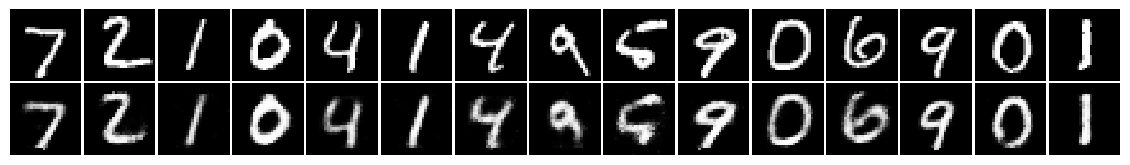

epoch 1 | iter 465 | loss 0.01434
epoch 1 | iter 470 | loss 0.01469


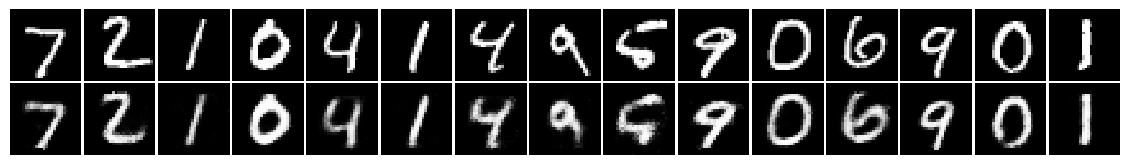

epoch 2 | iter 475 | loss 0.01458
epoch 2 | iter 480 | loss 0.01463


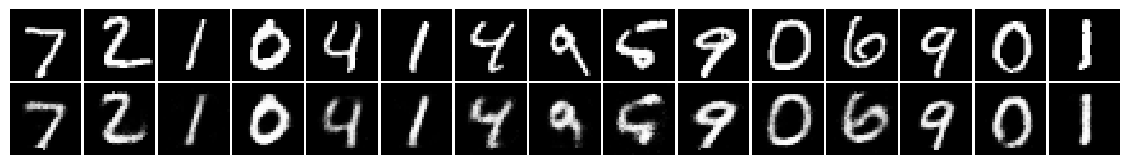

epoch 2 | iter 485 | loss 0.01504
epoch 2 | iter 490 | loss 0.01436


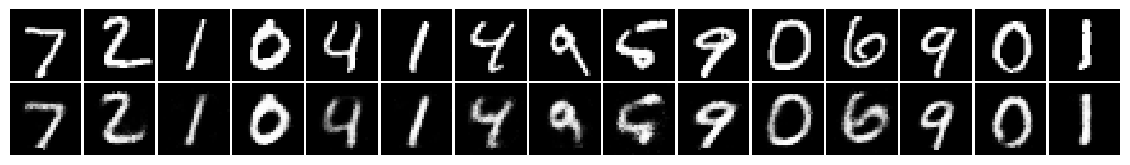

epoch 2 | iter 495 | loss 0.01479
epoch 2 | iter 500 | loss 0.01477


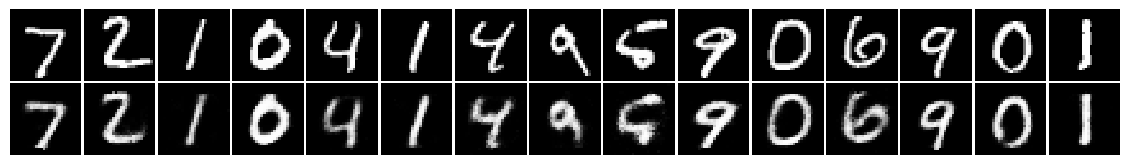

In [19]:
train_ae(train_dl, valid_dl, ae, 50, 500)

## Vanilla Variational Auto Encoder

Now we will reuse Encoder and Decoder modules from above to build a simple variational auto encoder.
Architecture is somewhat similar to showed bellow (with 2 Linear Layers instead of 3).

![title](https://miro.medium.com/max/3374/1*22cSCfmktNIwH5m__u2ffA.png)

### Variational Auto Encoder Module

In [20]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int, z_dim: int):
        super().__init__()
        
        self.enc = Encoder(inp_shape, hidden_dim, out_dim)
        self.dec = Decoder(inp_shape, hidden_dim, out_dim)
        
        self.mu     = nn.Linear(out_dim, z_dim)
        self.logvar = nn.Linear(out_dim, z_dim)
        
        self.fc = nn.Linear(z_dim, out_dim)
        
        init_weights(self)
        
    def encode(self, x):
        """This function takes x and produces mean and log(variance) for approximate posterior Q(z|x)"""
        
        enc = self.enc(x)
        
        mu, logvar = self.mu(enc), self.logvar(enc)
        
        return mu, logvar
        
    def sample_z(self, mu, logvar):
        """This function takes mean and log(variance) and applies reparametrization trick."""
        
        eps = torch.rand_like(mu)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        """This function accepts z - latent vector and produces reconstruction of original input."""
        
        return self.dec(self.fc(z))
        
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z)

In [21]:
VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2)

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=256, bias=True)
)

### ELBO loss

In [22]:
def elbo_loss(inp, tar, mu, logvar, alpha: float = 1, beta: float = 1):
    """This function defines ELBO loss, KL DIV + RECONSTRUCTION."""
    
    recon_loss = nn.functional.mse_loss(inp, tar, reduction='none').sum(dim=(1, 2, 3))
            
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = torch.mean(alpha * kld_loss + beta * recon_loss)
    
    return loss, torch.mean(recon_loss), torch.mean(kld_loss)

### Training Loop

In [23]:
def train_vae(train_dl: DataLoader, 
              valid_dl: DataLoader,
              model: nn.Module,
              n_epochs: int,
              max_iters: int = -1):
    
    LOG_INTERVAL = 20
    SUMMARY_INTERVAL = 100
    
    model = model.cuda()
    
    model.train()
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
    
    i = 1
    for epoch in range(n_epochs):
        for x, y in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()

            mu, logvar = model.encode(x)
            
            z = model.sample_z(mu, logvar)
        
            x_recon = model.decode(z)
        
            loss, recon_loss, kld_loss = elbo_loss(x_recon, x, mu, logvar, alpha=1, beta=1)

            acc_recon_loss += recon_loss.item()
            acc_kld_loss += kld_loss.item()
            acc_loss += loss.item()
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                
                print('epoch %d | iter %d | loss %.5f | KL loss %.5f | recon loss %.5f ' % 
                      (epoch + 1, i + 1, acc_loss / LOG_INTERVAL, acc_kld_loss / LOG_INTERVAL,
                       acc_recon_loss / LOG_INTERVAL))
                
                acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return

### Training Variational Auto Encoder

Let's train the model for 500 iterations

In [24]:
vae = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=20)

In [25]:
vae

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=20, bias=True)
  (logvar): Linear(in_features=256, out_features=20, bias=True)
  (fc): Linear(in_features=20, out_features=256, bias=True)
)

epoch 1 | iter 20 | loss 95.86604 | KL loss 5.75425 | recon loss 90.11179 
epoch 1 | iter 40 | loss 48.71043 | KL loss 2.85680 | recon loss 45.85364 
epoch 1 | iter 60 | loss 39.88440 | KL loss 3.19683 | recon loss 36.68757 
epoch 1 | iter 80 | loss 34.89632 | KL loss 3.53021 | recon loss 31.36611 
epoch 1 | iter 100 | loss 31.63746 | KL loss 3.77407 | recon loss 27.86340 


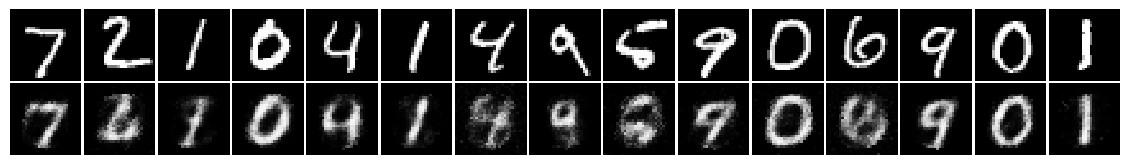

epoch 1 | iter 120 | loss 29.57842 | KL loss 3.99729 | recon loss 25.58113 
epoch 1 | iter 140 | loss 28.05492 | KL loss 4.14547 | recon loss 23.90945 
epoch 1 | iter 160 | loss 27.30063 | KL loss 4.20504 | recon loss 23.09558 
epoch 1 | iter 180 | loss 26.23046 | KL loss 4.27774 | recon loss 21.95272 
epoch 1 | iter 200 | loss 25.65221 | KL loss 4.38632 | recon loss 21.26589 


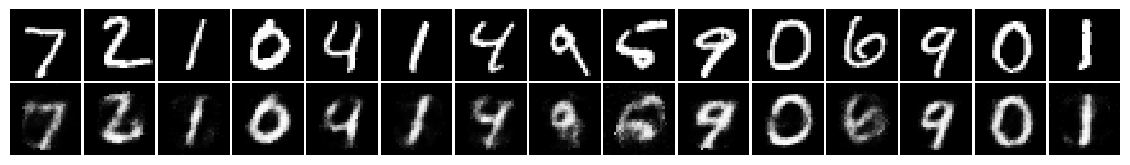

epoch 1 | iter 220 | loss 25.45854 | KL loss 4.40494 | recon loss 21.05361 
epoch 1 | iter 240 | loss 24.49404 | KL loss 4.46984 | recon loss 20.02420 
epoch 1 | iter 260 | loss 24.34133 | KL loss 4.47813 | recon loss 19.86321 
epoch 1 | iter 280 | loss 23.68702 | KL loss 4.51935 | recon loss 19.16767 
epoch 1 | iter 300 | loss 23.62305 | KL loss 4.54120 | recon loss 19.08185 


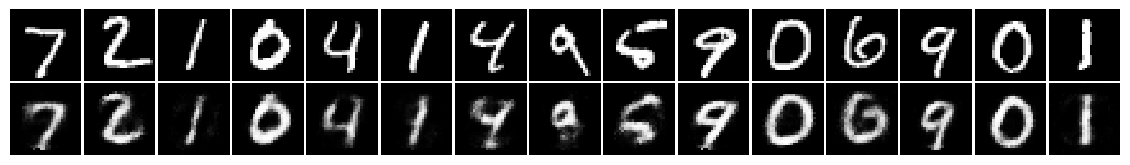

epoch 1 | iter 320 | loss 23.34999 | KL loss 4.58344 | recon loss 18.76655 
epoch 1 | iter 340 | loss 23.02573 | KL loss 4.52595 | recon loss 18.49979 
epoch 1 | iter 360 | loss 22.88286 | KL loss 4.53456 | recon loss 18.34830 
epoch 1 | iter 380 | loss 22.70801 | KL loss 4.54457 | recon loss 18.16344 
epoch 1 | iter 400 | loss 22.72307 | KL loss 4.68411 | recon loss 18.03896 


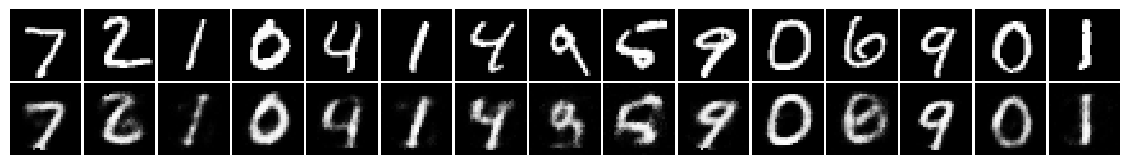

epoch 1 | iter 420 | loss 22.43454 | KL loss 4.61245 | recon loss 17.82209 
epoch 1 | iter 440 | loss 22.19619 | KL loss 4.65665 | recon loss 17.53955 
epoch 1 | iter 460 | loss 22.08733 | KL loss 4.64225 | recon loss 17.44508 
epoch 2 | iter 480 | loss 21.84346 | KL loss 4.61420 | recon loss 17.22926 
epoch 2 | iter 500 | loss 21.63841 | KL loss 4.67724 | recon loss 16.96117 


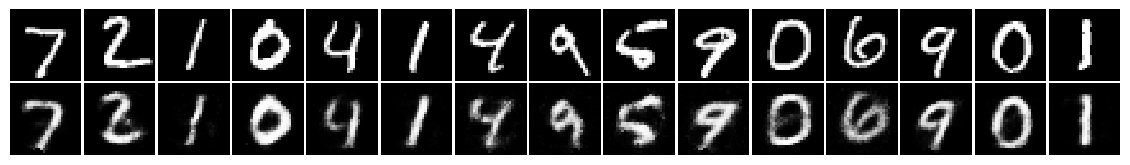

In [26]:
train_vae(train_dl, valid_dl, vae, 50, 500)

## Visualizing Latent Space

In this section we will work through several visualizations of above models to develop good intuition how these models work.  

In all below cases we will be using models with 2D latent space since its directly plottable without need of dimensionality reduction techniques, such as PCA. 

Besides, we will use pre-trained model weights because 2D latent space model training requires approx. 50 epochs on the data that would take long time to do it here.

### Download Pre-Trained Auto Encoder

In [27]:
if not os.path.exists('ae-20.model'):
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/ae-20.model

### Load Pre-Trained Auto Encoder with 2D latent space

In [28]:
ae = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=2)
ae.load_state_dict(torch.load('ae-20.model'))
ae.eval()

AutoEncoder(
  (ae): Sequential(
    (0): Encoder(
      (enc): Sequential(
        (0): Flatten()
        (1): Linear(in_features=784, out_features=512, bias=True)
        (2): ReLU()
        (3): Linear(in_features=512, out_features=2, bias=True)
      )
    )
    (1): Decoder(
      (dec): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
  )
)

### Get Latent Representations of Validation Set

We will start by visualizing the clusters of digits by plotting latent vectors of datapoints from validation set.

We will go over validation set and generate latent representation of every data point by using encoder part 
of the model. X and Y coordinates of this latent vectors, along with the label are stored in pandas Dataframe.

In [29]:
z, labels = [], []
for i, (x, y) in enumerate(valid_dl):
    enc = ae.ae[0](x).detach() # doing forward-pass only on encoder part.
    z.append(enc)
    labels.append(y)
z = torch.cat(z, dim=0)
labels = torch.cat(labels, dim=0)

df = pd.DataFrame({'x': z[:,0].numpy(), 
                   'y': z[:,1].numpy(),
                   'label': labels.numpy()})

df.head()

x         y  label
0  1.105610  4.956746      7
1 -0.581305 -0.078693      2
2 -6.466476  6.207766      1
3  1.150499 -0.204559      0
4  1.584186  2.257911      4

### Show latents of digits from validation set

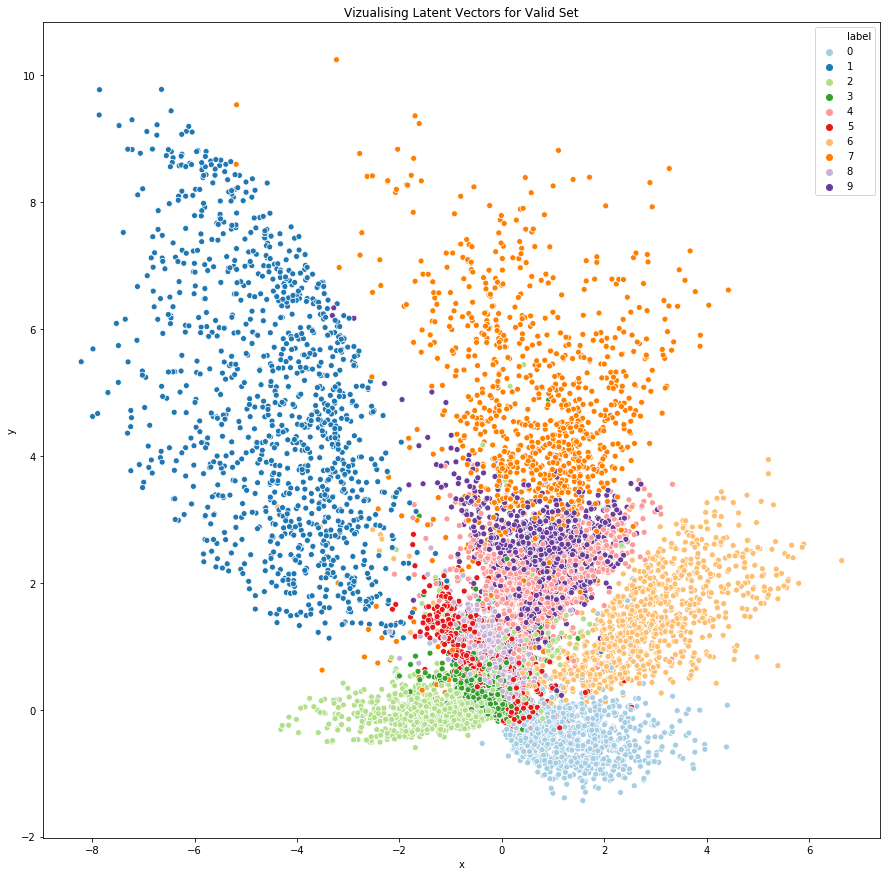

In [30]:
plt.figure(figsize=(15, 15))
sns.scatterplot(x="x", y="y", hue="label", palette=sns.color_palette("Paired", 10), data=df, legend="full")
plt.title('Vizualising Latent Vectors for Valid Set');

Now we will do the same visualization for variational auto-encoder

### Download Pre-Trained Variational Auto Encoder

In [31]:
if not os.path.exists('vae-60.model'):
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/vae-60.model

### Load Pre-Trained Variational Auto Encoder with 2D latent space

In [32]:
vae = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2)
vae.load_state_dict(torch.load('vae-60.model'))
vae.eval()

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=256, bias=True)
)

### Function for showing clusters of VAE

In [33]:
def viz_vae_clusters(vae: nn.Module):

    vae.cuda()
    z, labels = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl):
            x = x.cuda()
            mu, _ = vae.encode(x)
            z.append(mu.cpu())
            labels.append(y)
    z = torch.cat(z, dim=0)
    labels = torch.cat(labels, dim=0)

    df = pd.DataFrame({'x': z[:,0].numpy(), 
                  'y': z[:,1].numpy(),
                  'label': labels.numpy()})

    plt.figure(figsize=(15, 15))
    sns.scatterplot(x="x", y="y", hue="label", palette=sns.color_palette("Paired", 10), data=df, legend="full")
    plt.title('Vizualising Latent Vectors for Valid Set');

### Visualize 2D latents of VAE

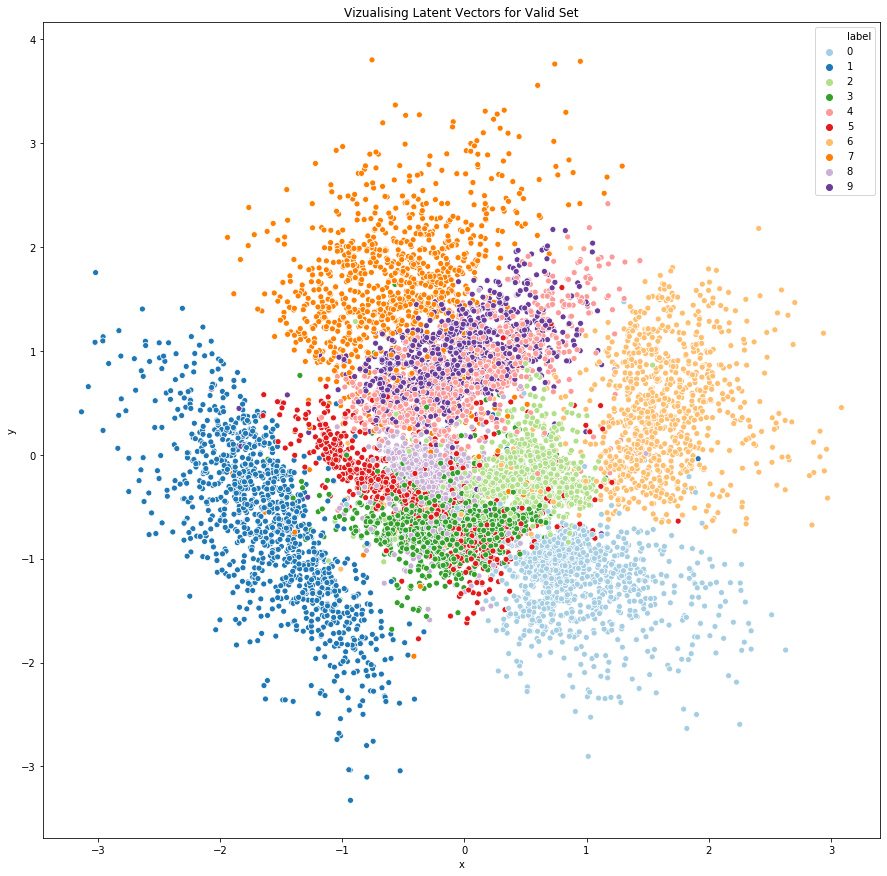

In [34]:
viz_vae_clusters(vae)

As you will see from above plot, point cloud of latent vectors has circular shape centered at origin as opposed to 
Auto Encoder case. This behaviour is imposed by KL Divergence component of the loss, that forces latent distribution to be close to the `isotropic Gaussian`.

Now we will see what happens if we remove KL Divergence term and only use reconstruction loss.

### Download Pre-Trained Variational Auto Encoder without KL component

In [35]:
if not os.path.exists('vae-60-kl0.model'):
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/vae-60-kl0.model

### Load Pre-Trained Variational Auto Encoder with 2D latent space and without KL component

In [36]:
vae_kl = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2)
vae_kl.load_state_dict(torch.load('vae-60-kl0.model'))
vae_kl.eval()

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=256, bias=True)
)

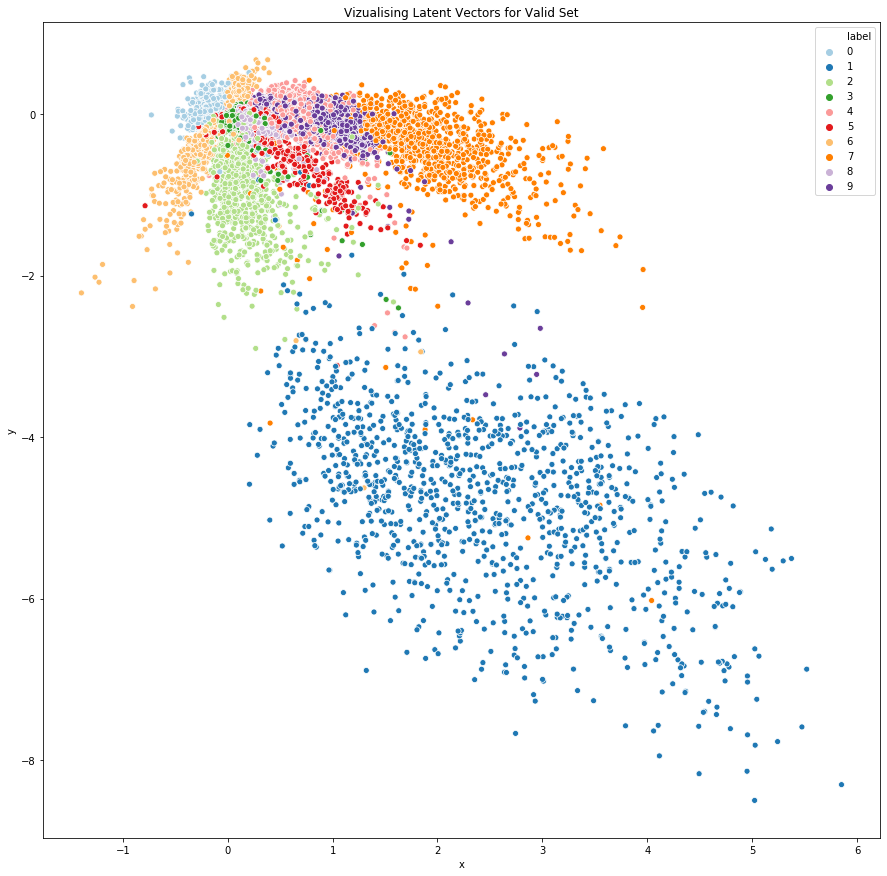

In [37]:
viz_vae_clusters(vae_kl)

## Show Continuity of VAE's Latent Space 

Now we will show that latent space of Variational Auto-Encoder is continuous, i.e. close latent vectors produce similar looking images at the output.

We will do it by visualizing whole 2D space at once (run the below cell to see what it means).

We will exploit the fact that our latent vectors are distributed somewhat similar to 2D isotropic gaussian centered at origin (refer above plots). Having said this, we need to generate 2D meshgrid where distribution of points correspond to 2D Gaussian.


To do this, we gonna first generate 2D meshgrid in $[0, 1]^2$ unit square and use inverse CDF (Comulative Distribution Function) of Gaussian to translate our meshgrid to the latent space.

Finally, we decode every point in latent space and visualize output images as 2D plot.



In [38]:
def draw_mnist_manifold_vae(model: nn.Module, size: int = 20):
    """This function takes a trained VAE with z_dim=2 and visualizes its latent space."""

    # generate a 2D point cloud of latent space using inverse CDF of Standard Gaussian.
    x_axes = ndist.ppf(np.linspace(0.05, 0.95, size))
    y_axes = ndist.ppf(np.linspace(0.05, 0.95, size))

    # preparing input to decoder.
    z = []
    for i, y in enumerate(x_axes):
        for j, x in enumerate(y_axes):
            z.append(torch.Tensor([x, y]))
    z = torch.stack(z)
    
    # decoding latent vectors
    preds = model.decode(z).detach()
    
    # rendering a single image from predictions.
    grid = make_grid(preds, pad_value=1, padding=1, nrow=size)[0].numpy()
    
    # showing the image.
    plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('2D Latent Space')
    plt.show()

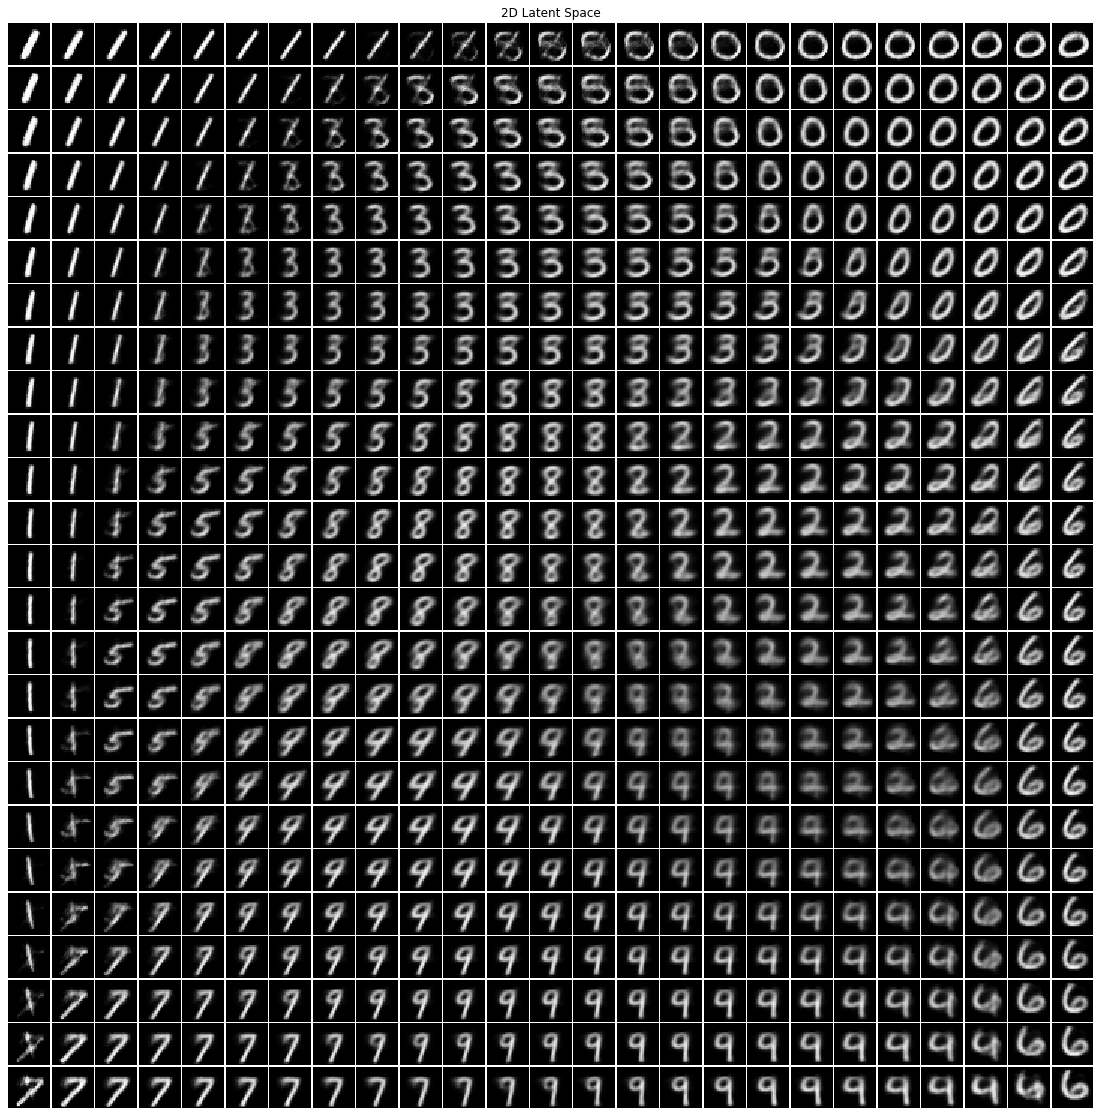

In [39]:
draw_mnist_manifold_vae(vae.cpu(), size=25);

## Show Non-Continuity of AE's Latent Space 

Doing similar visualization on Auto Encoder produces bad result, because the latent space usually isn't continuous.

More specifically, in some regions of space we get outputs that <b>don't represent valid digits</b>.

In [40]:
def draw_mnist_manifold_ae(model: nn.Module, size: int = 20):
    """This function takes a trained VAE with z_dim=2 and visualizes its latent space."""

    # generate a 2D point cloud of latent space using inverse CDF of Standard Gaussian.
    x_axes = np.linspace(-8, 6, size)
    y_axes = np.linspace(-1.5, 10, size)

    # assembling the latent vector of shape (size^2, 2) to be fed into the decoder.
    z = []
    for i, y in enumerate(x_axes):
        for j, x in enumerate(y_axes):
            z.append(torch.Tensor([x, y]))
    z = torch.stack(z)
    
    # generating predictions
    preds = model.ae[1](z).detach()
    
    # rendering a single image from predictions.
    grid = make_grid(preds, pad_value=1, padding=1, nrow=size)[0].numpy()
    
    # showing the image.
    plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('2D Latent Space')
    plt.show()
    

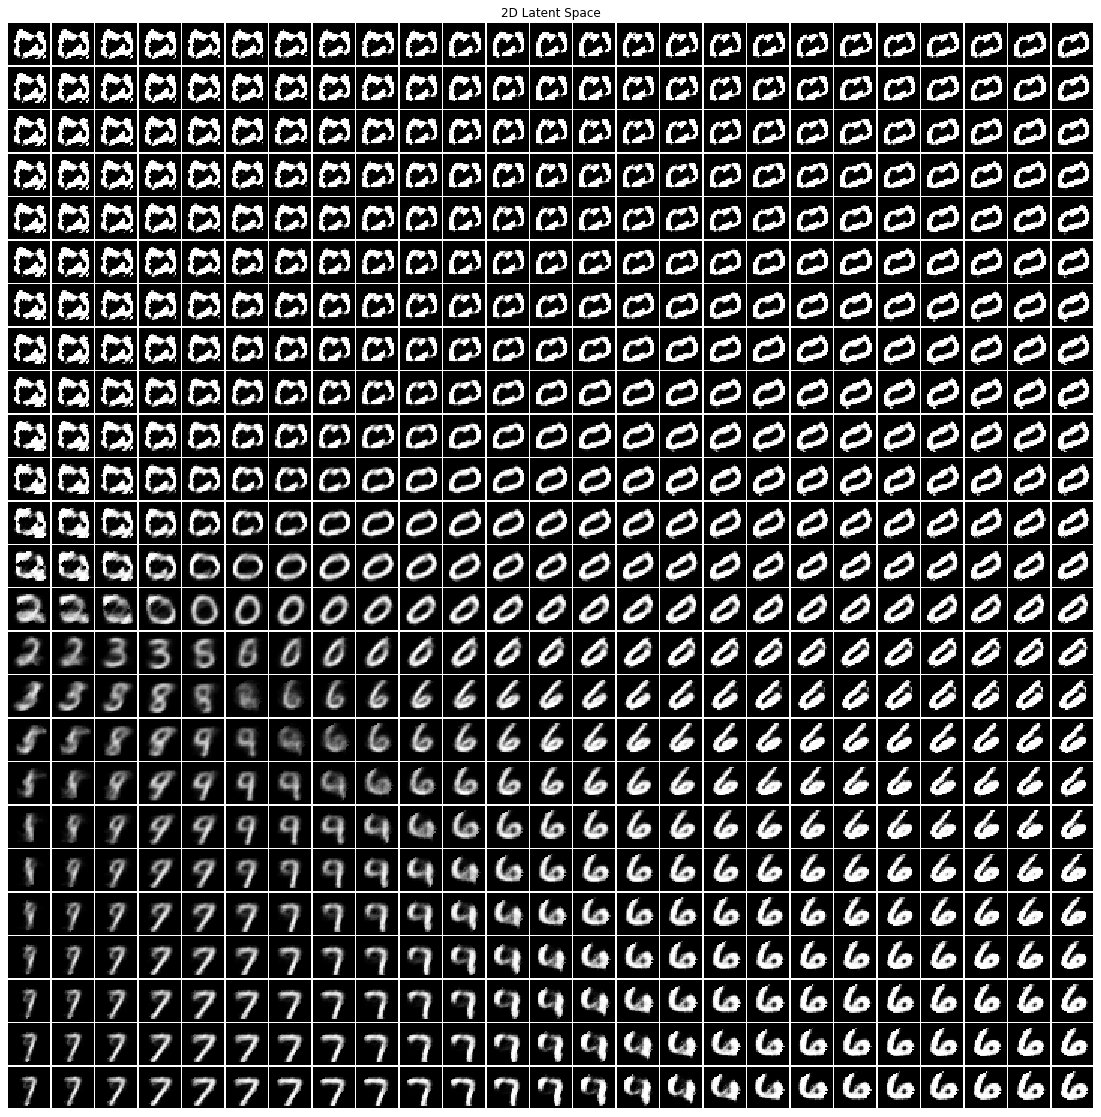

In [41]:
draw_mnist_manifold_ae(ae.cpu(), 25)

## Sampling from VAE

One of the goals of generative models is being able to effectively sample from learned data distribution.  

In case of VAE, we take trained model, remove its encoder, and use decoder to transform gaussian noise into data point.

### generate 100 gaussian noise vectors

In [42]:
z = torch.empty(100, 2).normal_(0, 1)
z.shape

torch.Size([100, 2])

### decode the noise vectors

In [43]:
images = vae.decode(z)

### plot the result

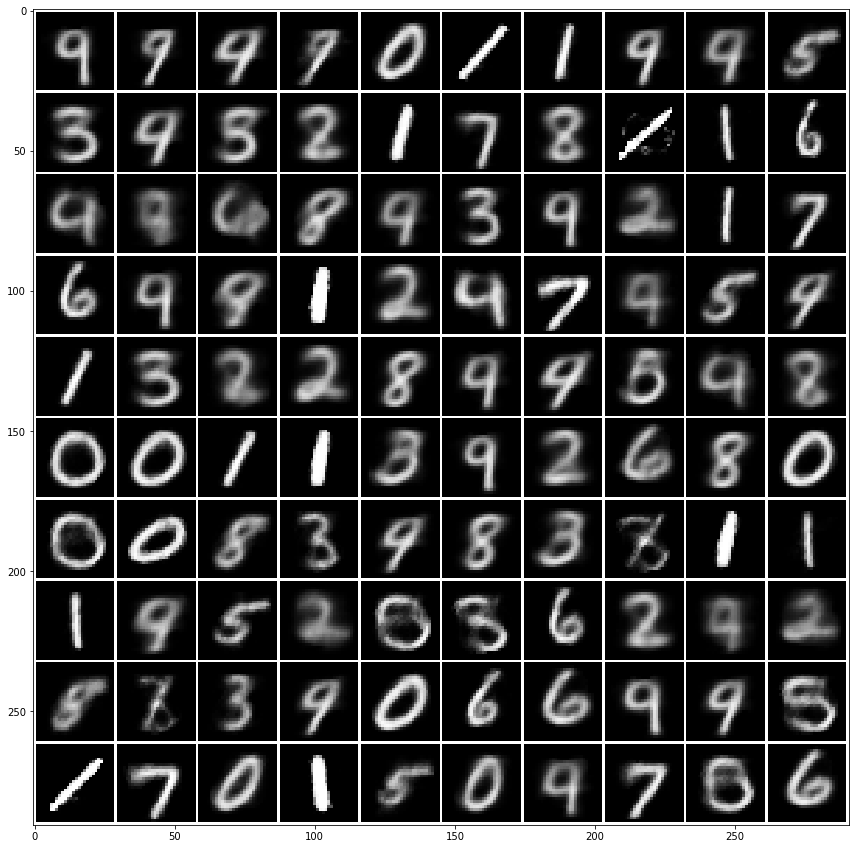

In [44]:
grid = make_grid(images, pad_value=1, padding=1, nrow=10)[0].detach().numpy()
plt.figure(figsize=(15, 15))
plt.imshow(grid, cmap='gray');

## Robustness of continuous latent space 

Continuity of latent space implies certain <b>robustness</b> agains noise.  

We can take latent vector corresponding to some digit, add small noise to it and still get output very similar to that digit.

### Take centers of each digit in latent space

Here we calculate average latent vector for every digit 0-9.
average is taken to make sure we have representative vector, i.e we are somewhere close to the centroid of that digit's cluster.

In [45]:
locs = [torch.zeros(1, 1, 2) for _ in range(10)] # list for keeping latent vectors corresponding to digits 0-9
locs_cnt = [0] * 10 # list for keeping counts of latent vectors per digits. 

for i, (x, y) in enumerate(valid_dl.dataset):
    mu, _ = vae.encode(x.unsqueeze(0))
    locs[y] += mu
    locs_cnt[y] += 1
    if i > 500:
        break
        
for i in range(len(locs)): locs[i] /= locs_cnt[i]

### Add small noise to taken centers to change "handwriting"

Show how to generate same digit in different `"handwriting"` by taking average vector of that digit and adding small noise. 

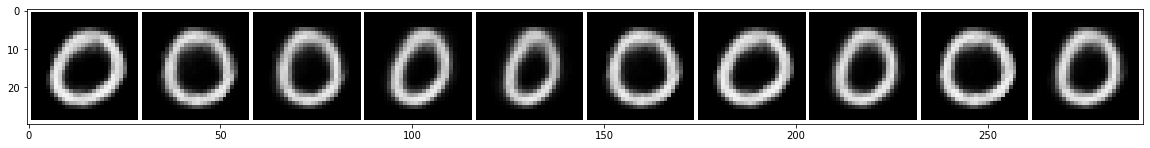

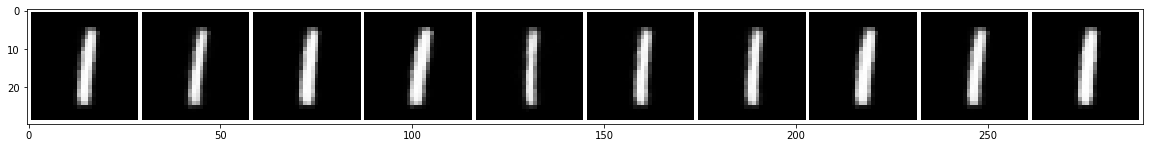

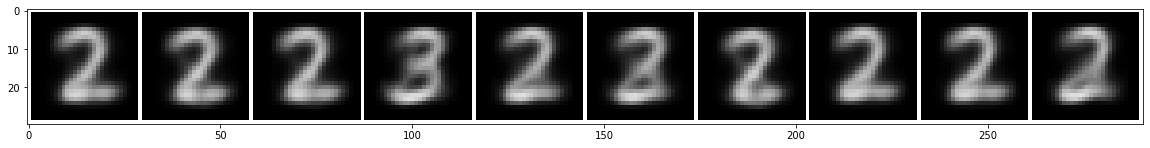

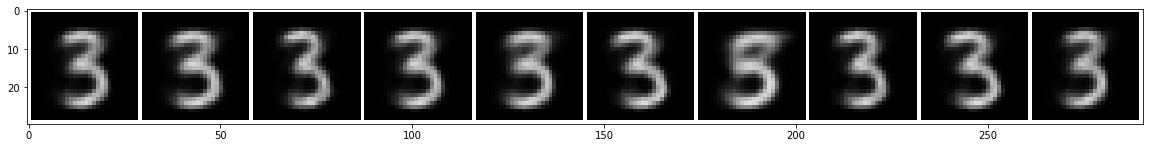

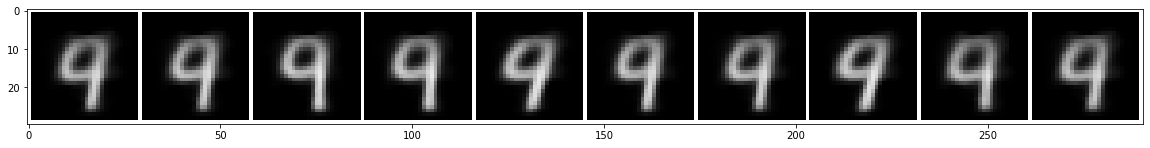

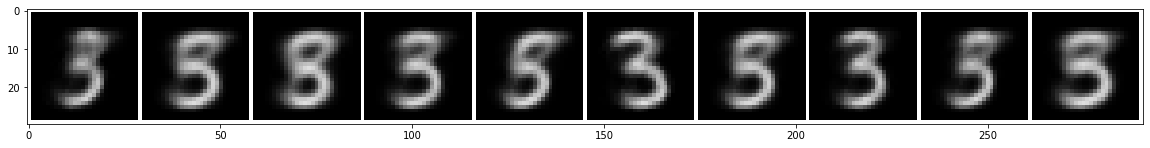

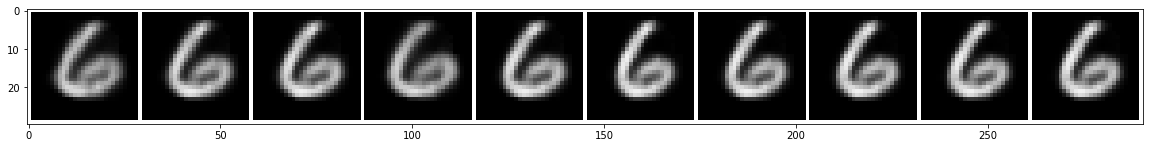

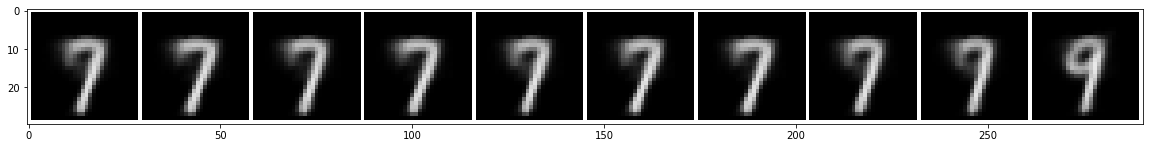

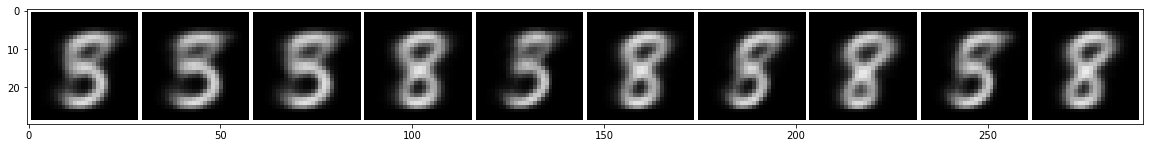

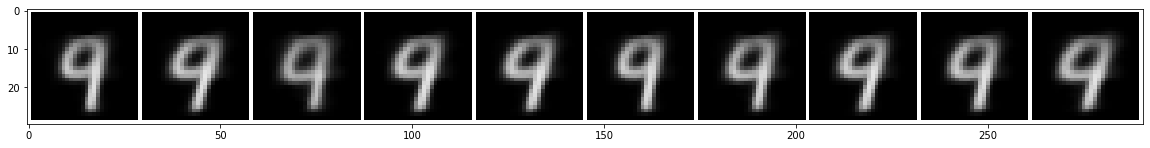

In [46]:
for i in range(10):
    x_recon = []
    for j in range(10):
        loc = locs[i].clone()
        loc += torch.empty_like(loc).normal_()/8
        x_recon.append(vae.decode(loc))
        
    x_recon = torch.cat(x_recon)
    
    grid = make_grid(x_recon, pad_value=1, padding=1, nrow=20)[0].detach().numpy()
    plt.figure(figsize=(20, 5))
    plt.imshow(grid, cmap='gray')
    plt.show()

## Summary

As we see Variational Auto Encoders are better than Vanilla Auto Encoders since they encode in continuous space which is robust to small changes in input data and we are getting smooth transitions between generated samples. 

You can check somewhat similar experiments on MNIST and other datasets in this [blog](https://www.jeremyjordan.me/variational-autoencoders/). 